In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from mamba_ssm import Mamba
from sklearn.model_selection import train_test_split

print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/khanteyl/miniconda3/envs/mamba/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA available: True


In [2]:
# Load data
df = pd.read_csv("/home/khanteyl/polymers/FFV_subset_not_nan.csv")
smiles_list = df["SMILES"].astype(str).tolist()
ffv_list = df["FFV"].astype(float).tolist()
print(f"Loaded {len(smiles_list)} samples")

Loaded 7030 samples


# Build SMILES Tokenizer (Improved Version)
**Using improved tokenizer that handles multi-character atoms and SMILES patterns**

In [3]:
# Improved SMILES Tokenizer
# Handles multi-character atoms (Cl, Br, [NH], etc.) and ring numbers properly

def improved_smiles_tokenizer(smiles):
    """
    Tokenizes SMILES by handling:
    - Multi-character atoms (Cl, Br, etc.)
    - Bracketed atoms ([NH], [Cl], [C+], etc.)
    - Ring numbers (1, 12, etc.)
    """
    tokens = []
    i = 0
    n = len(smiles)
    
    while i < n:
        char = smiles[i]
        
        # Handle bracketed atoms: [NH], [Cl], [C+], [13C], etc.
        if char == '[':
            end = smiles.find(']', i)
            if end != -1:
                tokens.append(smiles[i:end+1])  # Include brackets
                i = end + 1
                continue
        
        # Handle two-letter atoms: Cl, Br, etc.
        if i < n - 1 and char.isupper() and smiles[i+1].islower():
            tokens.append(smiles[i:i+2])
            i += 2
            continue
        
        # Handle ring numbers (can be 1-2 digits)
        if char.isdigit():
            if i < n - 1 and smiles[i+1].isdigit():
                tokens.append(smiles[i:i+2])  # Two-digit ring number
                i += 2
            else:
                tokens.append(char)  # Single digit
                i += 1
            continue
        
        # Handle other characters (single atoms, bonds, etc.)
        tokens.append(char)
        i += 1
    
    return tokens

# Build vocabulary from all tokens
print("Building improved SMILES tokenizer...")
all_tokens = set()
for smiles in smiles_list:
    tokens = improved_smiles_tokenizer(smiles)
    all_tokens.update(tokens)

# Add special tokens
PAD = "<pad>"
BOS = "<bos>"
EOS = "<eos>"

itos = [PAD, BOS, EOS] + sorted(all_tokens)
stoi = {token: i for i, token in enumerate(itos)}

pad_idx = stoi[PAD]
bos_idx = stoi[BOS]
eos_idx = stoi[EOS]

vocab_size = len(itos)
print(f"Vocab size: {vocab_size} (improved from character-level)")

def encode_smiles(s: str, add_bos=True, add_eos=True):
    """Encode SMILES using improved tokenizer"""
    tokens = improved_smiles_tokenizer(s)
    encoded = []
    if add_bos:
        encoded.append(bos_idx)
    for token in tokens:
        encoded.append(stoi[token])
    if add_eos:
        encoded.append(eos_idx)
    return encoded

# Encode all SMILES
encoded = [encode_smiles(s) for s in smiles_list]
max_len = max(len(t) for t in encoded)

# Show comparison
char_level_len = sum(len(s) for s in smiles_list[:10]) / 10
improved_len = sum(len(encode_smiles(s)) for s in smiles_list[:10]) / 10

print(f"Max token length: {max_len}")
print(f"Average sequence length (sample): {improved_len:.1f} tokens (vs ~{char_level_len:.1f} character-level)")
print(f"\nExample tokenization:")
example = smiles_list[0]
print(f"  SMILES: {example}")
example_tokens = improved_smiles_tokenizer(example)
print(f"  Tokens: {example_tokens[:20]}..." if len(example_tokens) > 20 else f"  Tokens: {example_tokens}")


Building improved SMILES tokenizer...
Vocab size: 89 (improved from character-level)
Max token length: 305
Average sequence length (sample): 74.0 tokens (vs ~78.9 character-level)

Example tokenization:
  SMILES: *CC(*)c1ccccc1C(=O)OCCCCCC
  Tokens: ['*', 'C', 'C', '(', '*', ')', 'c', '1', 'c', 'c', 'c', 'c', 'c', '1', 'C', '(', '=', 'O', ')', 'O']...


# Train/Val Split and Dataset

In [4]:
# Train/validation split
train_tokens, val_tokens, train_ffv, val_ffv = train_test_split(
    encoded, ffv_list, test_size=0.2, random_state=42
)

# Normalize targets (compute stats from training set only)
train_ffv_array = np.array(train_ffv)
ffv_mean = train_ffv_array.mean()
ffv_std = train_ffv_array.std()
print(f"FFV statistics (from training set): mean={ffv_mean:.4f}, std={ffv_std:.4f}")

train_ffv_normalized = [(t - ffv_mean) / ffv_std for t in train_ffv]
val_ffv_normalized = [(t - ffv_mean) / ffv_std for t in val_ffv]

normalization_stats = {"mean": ffv_mean, "std": ffv_std}

# Dataset class
class SmilesFFVDataset(Dataset):
    def __init__(self, token_lists, ffv_values):
        self.token_lists = token_lists
        self.ffv_values = ffv_values

    def __len__(self):
        return len(self.token_lists)

    def __getitem__(self, idx):
        tokens = torch.tensor(self.token_lists[idx], dtype=torch.long)
        ffv = torch.tensor(self.ffv_values[idx], dtype=torch.float32)
        return tokens, ffv

def collate_fn(batch):
    token_seqs, ffvs = zip(*batch)
    lengths = [len(seq) for seq in token_seqs]
    max_len = max(lengths)

    padded = torch.full((len(batch), max_len), pad_idx, dtype=torch.long)
    for i, seq in enumerate(token_seqs):
        padded[i, :len(seq)] = seq

    ffvs = torch.stack(ffvs)
    lengths = torch.tensor(lengths, dtype=torch.long)
    return padded, ffvs, lengths

# Create datasets and loaders
train_dataset = SmilesFFVDataset(train_tokens, train_ffv_normalized)
val_dataset = SmilesFFVDataset(val_tokens, val_ffv_normalized)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")


FFV statistics (from training set): mean=0.3671, std=0.0289
Train samples: 5624, Val samples: 1406


In [6]:
# Training Functions
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    n_samples = 0

    for tokens, ffvs, lengths in loader:
        tokens = tokens.to(device)
        ffvs = ffvs.to(device)
        lengths = lengths.to(device)

        optimizer.zero_grad()
        preds = model(tokens, lengths)
        loss = criterion(preds, ffvs)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        batch_size = tokens.size(0)
        total_loss += loss.item() * batch_size
        n_samples += batch_size

    return total_loss / n_samples

@torch.no_grad()
def evaluate_with_denorm(model, loader, criterion, device, ffv_mean, ffv_std):
    """Evaluate and compute R² on original (denormalized) scale"""
    model.eval()
    total_loss = 0.0
    n_samples = 0
    all_preds_norm = []
    all_targets_norm = []

    for tokens, ffvs, lengths in loader:
        tokens = tokens.to(device)
        ffvs = ffvs.to(device)
        lengths = lengths.to(device)

        preds_norm = model(tokens, lengths)
        loss = criterion(preds_norm, ffvs)

        batch_size = tokens.size(0)
        total_loss += loss.item() * batch_size
        n_samples += batch_size

        all_preds_norm.append(preds_norm.cpu())
        all_targets_norm.append(ffvs.cpu())

    # Denormalize predictions and targets
    preds_norm = torch.cat(all_preds_norm)
    targets_norm = torch.cat(all_targets_norm)
    
    preds_orig = preds_norm * ffv_std + ffv_mean
    targets_orig = targets_norm * ffv_std + ffv_mean

    # Metrics on normalized scale
    mse_norm = total_loss / n_samples
    mae_norm = torch.mean(torch.abs(preds_norm - targets_norm)).item()

    # Metrics on original scale
    mse_orig = torch.mean((preds_orig - targets_orig)**2).item()
    mae_orig = torch.mean(torch.abs(preds_orig - targets_orig)).item()

    # R² on original scale
    ss_res = torch.sum((preds_orig - targets_orig)**2).item()
    ss_tot = torch.sum((targets_orig - targets_orig.mean())**2).item()
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else 0.0

    return mse_norm, mae_norm, mse_orig, mae_orig, r2


# Training Functions

# Improved Model: Larger Architecture for Better R²


In [9]:
# Mega Model for FFV: Much larger with better architecture
class MegaMambaFFVRegressor(nn.Module):
    def __init__(self, vocab_size, d_model=512, d_state=16, d_conv=4, expand=2, 
                 pad_idx=0, n_layers=3, dropout=0.25):
        super().__init__()
        self.pad_idx = pad_idx

        self.embed = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        
        # Stack multiple Mamba layers with residual connections
        self.mamba_layers = nn.ModuleList([
            Mamba(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand)
            for _ in range(n_layers)
        ])
        self.layer_norms = nn.ModuleList([
            nn.LayerNorm(d_model) for _ in range(n_layers)
        ])
        
        # Multi-head attention pooling (more sophisticated)
        self.attention_pool = nn.MultiheadAttention(d_model, num_heads=8, dropout=dropout, batch_first=True)
        
        self.dropout = nn.Dropout(dropout)
        
        # Very deep regression head with skip connections
        self.head1 = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
        )
        self.head2 = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
        )
        self.head3 = nn.Linear(d_model // 2, 1)

    def forward(self, tokens, lengths):
        # Embedding
        x = self.embed(tokens)  # (B, L, d_model)
        
        # Stacked Mamba layers with residual connections
        for mamba, norm in zip(self.mamba_layers, self.layer_norms):
            residual = x
            x = mamba(x)
            x = norm(x)
            x = self.dropout(x)
            x = x + residual
        
        # Multi-head attention pooling
        mask = (tokens != self.pad_idx)  # (B, L)
        attn_mask = ~mask  # True for padding
        
        # Use mean as query for pooling
        query = x.mean(dim=1, keepdim=True)  # (B, 1, d_model)
        pooled, _ = self.attention_pool(query, x, x, key_padding_mask=attn_mask)
        pooled = pooled.squeeze(1)  # (B, d_model)
        
        # Deep head with skip connections
        h1 = self.head1(pooled)
        h2 = self.head2(h1)
        out = self.head3(h2).squeeze(-1)  # (B,)
        return out

# Create mega model for FFV
model_mega_ffv = MegaMambaFFVRegressor(
    vocab_size=vocab_size,
    d_model=512,  # 50% larger than 256
    d_state=16,
    d_conv=4,
    expand=2,
    pad_idx=pad_idx,
    n_layers=3,  # More layers
    dropout=0.25  # Higher dropout for regularization
).to(device)

# Combined loss (MSE + MAE) for robustness
class CombinedFFVLoss(nn.Module):
    def __init__(self, mse_weight=0.7, mae_weight=0.3):
        super().__init__()
        self.mse_weight = mse_weight
        self.mae_weight = mae_weight
    
    def forward(self, pred, target):
        mse = nn.functional.mse_loss(pred, target)
        mae = nn.functional.l1_loss(pred, target)
        return self.mse_weight * mse + self.mae_weight * mae

criterion_mega_ffv = CombinedFFVLoss(mse_weight=0.7, mae_weight=0.3)
optimizer_mega_ffv = torch.optim.AdamW(model_mega_ffv.parameters(), lr=2e-4, weight_decay=2e-4)  # Higher weight decay
scheduler_mega_ffv = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_mega_ffv, mode='min', factor=0.5, patience=10)

print(f"Mega FFV model created: d_model=512, n_layers=3, multi-head attention")
print(f"Model parameters: {sum(p.numel() for p in model_mega_ffv.parameters()):,}")


Mega FFV model created: d_model=512, n_layers=3, multi-head attention
Model parameters: 6,577,665


In [ ]:
# Training Loop for Mega FFV Model
num_epochs = 500
patience = 30  # Reduced patience - stop earlier to prevent overfitting
no_improve = 0

best_val_r2 = float("-inf")
best_state = None
best_epoch = 0

print("Starting training with MEGA FFV model...")
print("=" * 80)

for epoch in range(1, num_epochs + 1):
    # Training
    train_mse = train_one_epoch(model_mega_ffv, train_loader, optimizer_mega_ffv, criterion_mega_ffv, device)
    
    # Validation
    val_mse_norm, val_mae_norm, val_mse_orig, val_mae_orig, val_r2 = evaluate_with_denorm(
        model_mega_ffv, val_loader, criterion_mega_ffv, device,
        normalization_stats["mean"], normalization_stats["std"]
    )
    
    # Learning rate scheduling
    scheduler_mega_ffv.step(val_mse_norm)
    current_lr = optimizer_mega_ffv.param_groups[0]['lr']
    
    # Print every 3 epochs or when R² improves
    if epoch % 3 == 0 or val_r2 > best_val_r2:
        print(
            f"Epoch {epoch:03d} | "
            f"train MSE: {train_mse:.4f} | "
            f"val R²: {val_r2:.4f} | "
            f"val MAE: {val_mae_orig:.2f}°C | "
            f"LR: {current_lr:.2e}"
        )

    # Check if validation R² improved
    if val_r2 > best_val_r2:
        improvement = val_r2 - best_val_r2
        best_val_r2 = val_r2
        best_epoch = epoch
        best_state = {
            "model": {k: v.cpu().clone() for k, v in model_mega_ffv.state_dict().items()},
            "stoi": stoi,
            "itos": itos,
            "normalization_stats": normalization_stats,
            "epoch": epoch,
            "val_r2": val_r2,
            "val_mae": val_mae_orig,
        }
        no_improve = 0
        if epoch % 3 != 0:
            print(f"Epoch {epoch:03d} | NEW BEST! R²: {val_r2:.4f} (improved by {improvement:.4f})")
    else:
        no_improve += 1

    # Early stopping
    if no_improve >= patience:
        print(f"\nEarly stopping at epoch {epoch} (no R² improvement for {patience} epochs)")
        print(f"Best R² was {best_val_r2:.4f} at epoch {best_epoch}")
        break

# Save best checkpoint
if best_state is not None:
    torch.save(best_state, "mamba_ffv_regressor_mega.pt")
    print(f"\n{'='*80}")
    print(f"Training complete! Best R²: {best_val_r2:.4f} at epoch {best_epoch}")
    
    # Reload best model and verify
    model_mega_ffv.load_state_dict(best_state["model"])
    final_mse_norm, final_mae_norm, final_mse_orig, final_mae_orig, final_r2 = evaluate_with_denorm(
        model_mega_ffv, val_loader, criterion_mega_ffv, device,
        normalization_stats["mean"], normalization_stats["std"]
    )
    print(f"\nFinal Results:")
    print(f"  R²: {final_r2:.4f}")
    print(f"  MAE: {final_mae_orig:.2f}")
    print(f"  MSE: {final_mse_orig:.2f}")
    
else:
    print("No best state saved - training may have failed")


Starting training with MEGA FFV model...
Epoch 001 | train MSE: 0.4712 | val R²: 0.6433 | val MAE: 0.01°C | LR: 2.00e-04
Epoch 001 | NEW BEST! R²: 0.6433 (improved by inf)
Epoch 002 | train MSE: 0.2786 | val R²: 0.7054 | val MAE: 0.01°C | LR: 2.00e-04
Epoch 002 | NEW BEST! R²: 0.7054 (improved by 0.0621)
Epoch 003 | train MSE: 0.2251 | val R²: 0.7363 | val MAE: 0.01°C | LR: 2.00e-04
Epoch 004 | train MSE: 0.2001 | val R²: 0.7481 | val MAE: 0.01°C | LR: 2.00e-04
Epoch 004 | NEW BEST! R²: 0.7481 (improved by 0.0118)
Epoch 006 | train MSE: 0.1733 | val R²: 0.7591 | val MAE: 0.01°C | LR: 2.00e-04
Epoch 007 | train MSE: 0.1381 | val R²: 0.7753 | val MAE: 0.01°C | LR: 2.00e-04
Epoch 007 | NEW BEST! R²: 0.7753 (improved by 0.0162)
Epoch 008 | train MSE: 0.1289 | val R²: 0.7815 | val MAE: 0.01°C | LR: 2.00e-04
Epoch 008 | NEW BEST! R²: 0.7815 (improved by 0.0061)
Epoch 009 | train MSE: 0.1314 | val R²: 0.7400 | val MAE: 0.01°C | LR: 2.00e-04
Epoch 010 | train MSE: 0.1128 | val R²: 0.7895 | val

# Parity Plot: Predicted vs Actual ffv


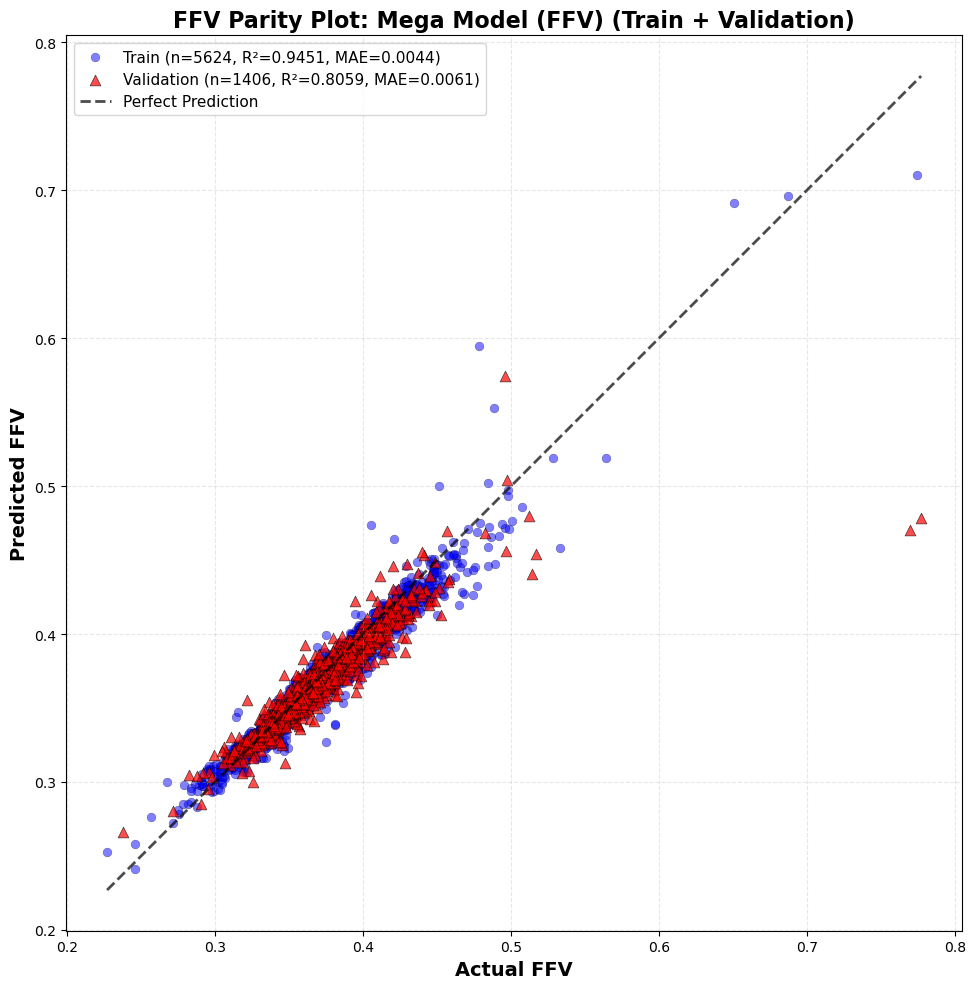


Train Set Metrics (FFV):
  R²: 0.9451
  MAE: 0.0044
  RMSE: 0.0068
  Samples: 5624

Validation Set Metrics (FFV):
  R²: 0.8059
  MAE: 0.0061
  RMSE: 0.0142
  Samples: 1406


In [13]:
import matplotlib.pyplot as plt
# Parity Plot with Both Train and Validation Sets (for FFV)
@torch.no_grad()
def get_all_predictions(model_or_models, train_loader, val_loader, device, ffv_mean, ffv_std, is_ensemble=False):
    """Get predictions for both train and validation sets (FFV)"""
    if is_ensemble:
        for model in model_or_models:
            model.eval()
    else:
        model_or_models.eval()
    
    def get_preds_from_loader(loader):
        all_preds_norm = []
        all_targets_norm = []
        
        for tokens, ffvs, lengths in loader:
            tokens = tokens.to(device)
            ffvs = ffvs.to(device)
            lengths = lengths.to(device)
            
            if is_ensemble:
                preds_list = []
                for model in model_or_models:
                    pred = model(tokens, lengths)
                    preds_list.append(pred)
                preds_norm = torch.stack(preds_list).mean(dim=0)
            else:
                preds_norm = model_or_models(tokens, lengths)
            
            all_preds_norm.append(preds_norm.cpu())
            all_targets_norm.append(ffvs.cpu())
        
        preds_norm = torch.cat(all_preds_norm)
        targets_norm = torch.cat(all_targets_norm)
        preds_orig = preds_norm * ffv_std + ffv_mean
        targets_orig = targets_norm * ffv_std + ffv_mean
        return preds_orig.numpy(), targets_orig.numpy()
    
    train_preds, train_actuals = get_preds_from_loader(train_loader)
    val_preds, val_actuals = get_preds_from_loader(val_loader)
    
    return train_preds, train_actuals, val_preds, val_actuals

# Get predictions for both sets
use_ensemble = False  # Set to True for ensemble

if use_ensemble and 'models' in locals() and len(models) > 0:
    train_preds, train_actuals, val_preds, val_actuals = get_all_predictions(
        models, train_loader, val_loader, device,
        normalization_stats["mean"], normalization_stats["std"], is_ensemble=True
    )
    model_name = "Ensemble"
else:
    model_to_use = model_mega_ffv if 'model_mega_ffv' in locals() else model
    train_preds, train_actuals, val_preds, val_actuals = get_all_predictions(
        model_to_use, train_loader, val_loader, device,
        normalization_stats["mean"], normalization_stats["std"], is_ensemble=False
    )
    model_name = "Mega Model (FFV)" if 'model_mega_ffv' in locals() else "Deep Model (FFV)"

# Calculate metrics
def calc_metrics(preds, actuals):
    mse = np.mean((preds - actuals)**2)
    mae = np.mean(np.abs(preds - actuals))
    rmse = np.sqrt(mse)
    ss_res = np.sum((preds - actuals)**2)
    ss_tot = np.sum((actuals - actuals.mean())**2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else 0.0
    return r2, mae, rmse

train_r2, train_mae, train_rmse = calc_metrics(train_preds, train_actuals)
val_r2, val_mae, val_rmse = calc_metrics(val_preds, val_actuals)

# Create parity plot with both sets
plt.figure(figsize=(12, 10))

# Plot train and validation
plt.scatter(
    train_actuals, train_preds,
    alpha=0.5, s=40, color='blue',
    edgecolors='black', linewidth=0.3,
    label=f'Train (n={len(train_preds)}, R²={train_r2:.4f}, MAE={train_mae:.4f})'
)

plt.scatter(
    val_actuals, val_preds,
    alpha=0.7, s=60, color='red',
    edgecolors='black', linewidth=0.5, marker='^',
    label=f'Validation (n={len(val_preds)}, R²={val_r2:.4f}, MAE={val_mae:.4f})'
)

# Add diagonal line
all_actuals = np.concatenate([train_actuals, val_actuals])
all_preds = np.concatenate([train_preds, val_preds])
min_val = min(all_actuals.min(), all_preds.min())
max_val = max(all_actuals.max(), all_preds.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, 
         label='Perfect Prediction', alpha=0.7)

# Labels and title for FFV (no units)
plt.xlabel('Actual FFV', fontsize=14, fontweight='bold')
plt.ylabel('Predicted FFV', fontsize=14, fontweight='bold')
plt.title(f'FFV Parity Plot: {model_name} (Train + Validation)', 
          fontsize=16, fontweight='bold')

# Grid and legend
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=11, loc='upper left')

# Equal aspect ratio
plt.gca().set_aspect('equal', adjustable='box')

# # Add metrics text box
# textstr = f'Train:\n  R² = {train_r2:.4f}\n  MAE = {train_mae:.4f}\n  RMSE = {train_rmse:.4f}\n  n = {len(train_preds)}\n\n' + \
#           f'Validation:\n  R² = {val_r2:.4f}\n  MAE = {val_mae:.4f}\n  RMSE = {val_rmse:.4f}\n  n = {len(val_preds)}'
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
# plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=11,
#          verticalalignment='top', bbox=props, family='monospace')

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"Train Set Metrics (FFV):")
print(f"  R²: {train_r2:.4f}")
print(f"  MAE: {train_mae:.4f}")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  Samples: {len(train_preds)}")
print(f"\nValidation Set Metrics (FFV):")
print(f"  R²: {val_r2:.4f}")
print(f"  MAE: {val_mae:.4f}")
print(f"  RMSE: {val_rmse:.4f}")
print(f"  Samples: {len(val_preds)}")
print(f"{'='*60}")


# Anti-Overfitting Model: Improved Regularization


In [14]:
# Regularized Model to Reduce Overfitting
class RegularizedMambaFFVRegressor(nn.Module):
    def __init__(self, vocab_size, d_model=384, d_state=16, d_conv=4, expand=2, 
                 pad_idx=0, n_layers=2, dropout=0.4):
        super().__init__()
        self.pad_idx = pad_idx

        self.embed = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.embed_dropout = nn.Dropout(dropout * 0.5)  # Embedding dropout
        
        # Fewer layers with more dropout
        self.mamba_layers = nn.ModuleList([
            Mamba(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand)
            for _ in range(n_layers)
        ])
        self.layer_norms = nn.ModuleList([
            nn.LayerNorm(d_model) for _ in range(n_layers)
        ])
        
        # Attention pooling with dropout
        self.attention_pool = nn.MultiheadAttention(d_model, num_heads=6, dropout=dropout, batch_first=True)
        
        self.dropout = nn.Dropout(dropout)
        
        # Simpler regression head with more dropout
        self.head1 = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
        )
        self.head2 = nn.Sequential(
            nn.Linear(d_model // 2, d_model // 4),
            nn.GELU(),
            nn.Dropout(dropout * 0.8),
        )
        self.head3 = nn.Linear(d_model // 4, 1)

    def forward(self, tokens, lengths):
        # Embedding with dropout
        x = self.embed(tokens)  # (B, L, d_model)
        x = self.embed_dropout(x)
        
        # Stacked Mamba layers with residual connections and dropout
        for mamba, norm in zip(self.mamba_layers, self.layer_norms):
            residual = x
            x = mamba(x)
            x = norm(x)
            x = self.dropout(x)
            x = x + residual
        
        # Multi-head attention pooling
        mask = (tokens != self.pad_idx)  # (B, L)
        attn_mask = ~mask  # True for padding
        
        # Use mean as query for pooling
        query = x.mean(dim=1, keepdim=True)  # (B, 1, d_model)
        pooled, _ = self.attention_pool(query, x, x, key_padding_mask=attn_mask)
        pooled = pooled.squeeze(1)  # (B, d_model)
        pooled = self.dropout(pooled)
        
        # Regression head
        h1 = self.head1(pooled)
        h2 = self.head2(h1)
        out = self.head3(h2).squeeze(-1)  # (B,)
        return out

# Create regularized model
model_reg_ffv = RegularizedMambaFFVRegressor(
    vocab_size=vocab_size,
    d_model=384,  # Reduced from 512
    d_state=16,
    d_conv=4,
    expand=2,
    pad_idx=pad_idx,
    n_layers=2,  # Reduced from 3
    dropout=0.4  # Increased from 0.25
).to(device)

# Standard MSE loss (simpler, less prone to overfitting)
criterion_reg_ffv = nn.MSELoss()

# Higher weight decay and lower learning rate
optimizer_reg_ffv = torch.optim.AdamW(
    model_reg_ffv.parameters(), 
    lr=1e-4,  # Reduced from 2e-4
    weight_decay=1e-3  # Increased from 2e-4
)
scheduler_reg_ffv = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_reg_ffv, mode='min', factor=0.5, patience=8, min_lr=1e-6
)

print(f"Regularized FFV model created:")
print(f"  d_model=384 (reduced), n_layers=2 (reduced), dropout=0.4 (increased)")
print(f"  Model parameters: {sum(p.numel() for p in model_reg_ffv.parameters()):,}")
print(f"  Learning rate: 1e-4, Weight decay: 1e-3")


Regularized FFV model created:
  d_model=384 (reduced), n_layers=2 (reduced), dropout=0.4 (increased)
  Model parameters: 2,647,297
  Learning rate: 1e-4, Weight decay: 1e-3


In [15]:
# Training Loop for Regularized Model
num_epochs = 500
patience = 25  # Early stopping patience
no_improve = 0

best_val_r2 = float("-inf")
best_state = None
best_epoch = 0

print("Starting training with REGULARIZED FFV model...")
print("=" * 80)

for epoch in range(1, num_epochs + 1):
    # Training
    train_mse = train_one_epoch(model_reg_ffv, train_loader, optimizer_reg_ffv, criterion_reg_ffv, device)
    
    # Validation
    val_mse_norm, val_mae_norm, val_mse_orig, val_mae_orig, val_r2 = evaluate_with_denorm(
        model_reg_ffv, val_loader, criterion_reg_ffv, device,
        normalization_stats["mean"], normalization_stats["std"]
    )
    
    # Learning rate scheduling
    scheduler_reg_ffv.step(val_mse_norm)
    current_lr = optimizer_reg_ffv.param_groups[0]['lr']
    
    # Print every 3 epochs or when R² improves
    if epoch % 3 == 0 or val_r2 > best_val_r2:
        print(
            f"Epoch {epoch:03d} | "
            f"train MSE: {train_mse:.4f} | "
            f"val R²: {val_r2:.4f} | "
            f"val MAE: {val_mae_orig:.4f} | "
            f"LR: {current_lr:.2e}"
        )

    # Check if validation R² improved
    if val_r2 > best_val_r2:
        improvement = val_r2 - best_val_r2
        best_val_r2 = val_r2
        best_epoch = epoch
        best_state = {
            "model": {k: v.cpu().clone() for k, v in model_reg_ffv.state_dict().items()},
            "stoi": stoi,
            "itos": itos,
            "normalization_stats": normalization_stats,
            "epoch": epoch,
            "val_r2": val_r2,
            "val_mae": val_mae_orig,
        }
        no_improve = 0
        if epoch % 3 != 0:
            print(f"Epoch {epoch:03d} | NEW BEST! R²: {val_r2:.4f} (improved by {improvement:.4f})")
    else:
        no_improve += 1

    # Early stopping
    if no_improve >= patience:
        print(f"\nEarly stopping at epoch {epoch} (no R² improvement for {patience} epochs)")
        print(f"Best R² was {best_val_r2:.4f} at epoch {best_epoch}")
        break

# Save best checkpoint
if best_state is not None:
    torch.save(best_state, "mamba_ffv_regressor_regularized.pt")
    print(f"\n{'='*80}")
    print(f"Training complete! Best R²: {best_val_r2:.4f} at epoch {best_epoch}")
    
    # Reload best model and verify
    model_reg_ffv.load_state_dict(best_state["model"])
    
    # Evaluate both train and validation
    train_mse_norm, train_mae_norm, train_mse_orig, train_mae_orig, train_r2 = evaluate_with_denorm(
        model_reg_ffv, train_loader, criterion_reg_ffv, device,
        normalization_stats["mean"], normalization_stats["std"]
    )
    final_mse_norm, final_mae_norm, final_mse_orig, final_mae_orig, final_r2 = evaluate_with_denorm(
        model_reg_ffv, val_loader, criterion_reg_ffv, device,
        normalization_stats["mean"], normalization_stats["std"]
    )
    
    print(f"\nFinal Results:")
    print(f"  Train R²: {train_r2:.4f} | Val R²: {final_r2:.4f}")
    print(f"  Train MAE: {train_mae_orig:.4f} | Val MAE: {final_mae_orig:.4f}")
    print(f"  Train MSE: {train_mse_orig:.4f} | Val MSE: {final_mse_orig:.4f}")
    print(f"\nOverfitting gap: {train_r2 - final_r2:.4f} (lower is better)")
    
else:
    print("No best state saved - training may have failed")


Starting training with REGULARIZED FFV model...
Epoch 001 | train MSE: 0.7335 | val R²: 0.5046 | val MAE: 0.0139 | LR: 1.00e-04
Epoch 001 | NEW BEST! R²: 0.5046 (improved by inf)
Epoch 002 | train MSE: 0.4000 | val R²: 0.6246 | val MAE: 0.0106 | LR: 1.00e-04
Epoch 002 | NEW BEST! R²: 0.6246 (improved by 0.1201)
Epoch 003 | train MSE: 0.3434 | val R²: 0.6522 | val MAE: 0.0095 | LR: 1.00e-04
Epoch 004 | train MSE: 0.2907 | val R²: 0.6725 | val MAE: 0.0087 | LR: 1.00e-04
Epoch 004 | NEW BEST! R²: 0.6725 (improved by 0.0203)
Epoch 005 | train MSE: 0.2819 | val R²: 0.6949 | val MAE: 0.0082 | LR: 1.00e-04
Epoch 005 | NEW BEST! R²: 0.6949 (improved by 0.0224)
Epoch 006 | train MSE: 0.2528 | val R²: 0.6880 | val MAE: 0.0090 | LR: 1.00e-04
Epoch 007 | train MSE: 0.2434 | val R²: 0.7183 | val MAE: 0.0076 | LR: 1.00e-04
Epoch 007 | NEW BEST! R²: 0.7183 (improved by 0.0234)
Epoch 008 | train MSE: 0.2322 | val R²: 0.7242 | val MAE: 0.0073 | LR: 1.00e-04
Epoch 008 | NEW BEST! R²: 0.7242 (improved by

## Anti-Overfitting Strategies Applied:

1. **Increased Dropout**: 0.25 → 0.4 (60% increase)
2. **Reduced Model Capacity**: 
   - d_model: 512 → 384 (25% reduction)
   - n_layers: 3 → 2 (33% reduction)
3. **Higher Weight Decay**: 2e-4 → 1e-3 (5x increase)
4. **Lower Learning Rate**: 2e-4 → 1e-4 (50% reduction)
5. **Simpler Loss Function**: Combined loss → MSE only
6. **Embedding Dropout**: Added dropout after embeddings
7. **More Aggressive LR Scheduling**: Reduced patience from 10 to 8

## Additional Strategies You Can Try:

- **Data Augmentation**: SMILES augmentation (randomization, rotation)
- **Cross-Validation**: Use k-fold CV instead of single train/val split
- **Ensemble**: Average predictions from multiple models
- **Label Smoothing**: Add noise to targets during training
- **Mixup**: Interpolate between samples (may not work well for SMILES)
- **Larger Batch Size**: Try batch_size=128 or 256
- **Gradient Clipping**: Already implemented (max_norm=1.0)


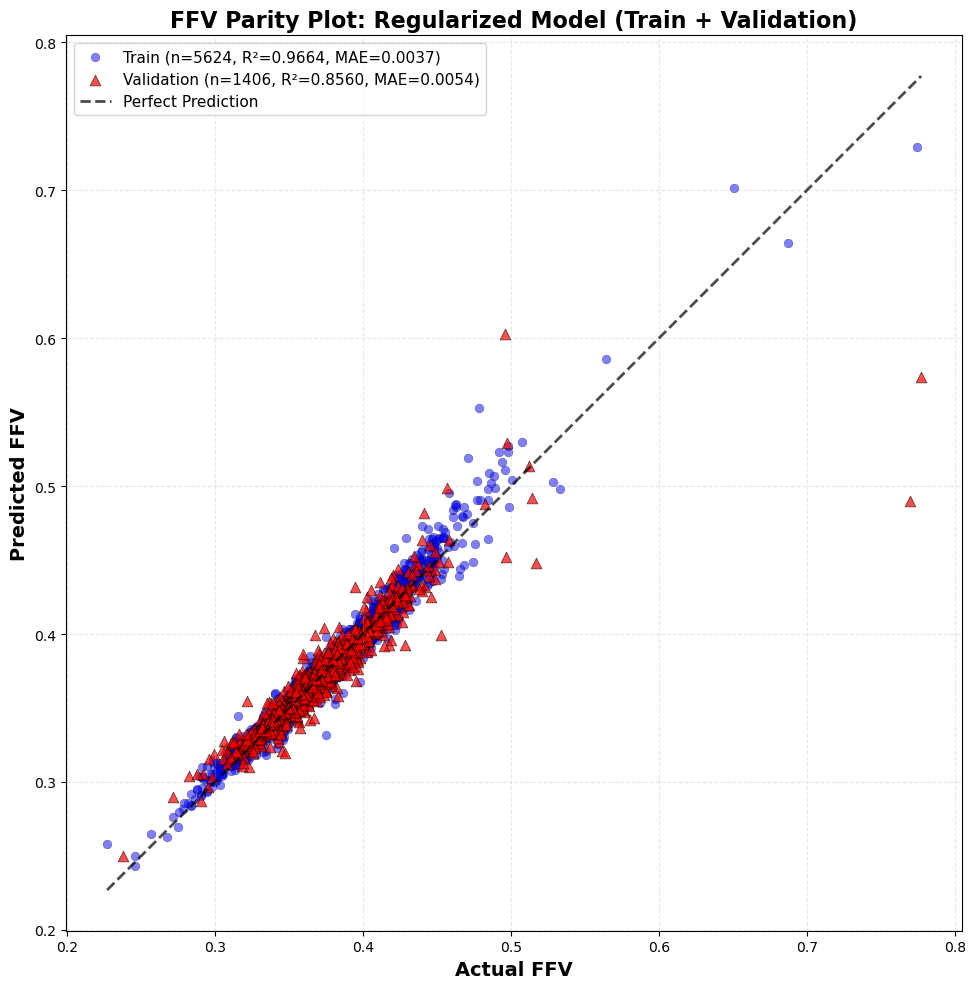


Regularized Model - Train Set Metrics:
  R²: 0.9664
  MAE: 0.0037
  RMSE: 0.0053

Regularized Model - Validation Set Metrics:
  R²: 0.8560
  MAE: 0.0054
  RMSE: 0.0122

Overfitting Gap: 0.1104

COMPARISON:
Original Model:
  Train R²: 0.9675 | Val R²: 0.8427 | Gap: 0.1249
Regularized Model:
  Train R²: 0.9664 | Val R²: 0.8560 | Gap: 0.1104

Improvement in overfitting gap: 0.0145


In [16]:
# Parity Plot for Regularized Model
if 'model_reg_ffv' in locals() and best_state is not None:
    # Get predictions for both sets
    train_preds_reg, train_actuals_reg, val_preds_reg, val_actuals_reg = get_all_predictions(
        model_reg_ffv, train_loader, val_loader, device,
        normalization_stats["mean"], normalization_stats["std"], is_ensemble=False
    )
    
    # Calculate metrics
    train_r2_reg, train_mae_reg, train_rmse_reg = calc_metrics(train_preds_reg, train_actuals_reg)
    val_r2_reg, val_mae_reg, val_rmse_reg = calc_metrics(val_preds_reg, val_actuals_reg)
    
    # Create parity plot
    plt.figure(figsize=(12, 10))
    
    # Plot train and validation
    plt.scatter(
        train_actuals_reg, train_preds_reg,
        alpha=0.5, s=40, color='blue',
        edgecolors='black', linewidth=0.3,
        label=f'Train (n={len(train_preds_reg)}, R²={train_r2_reg:.4f}, MAE={train_mae_reg:.4f})'
    )
    
    plt.scatter(
        val_actuals_reg, val_preds_reg,
        alpha=0.7, s=60, color='red',
        edgecolors='black', linewidth=0.5, marker='^',
        label=f'Validation (n={len(val_preds_reg)}, R²={val_r2_reg:.4f}, MAE={val_mae_reg:.4f})'
    )
    
    # Add diagonal line
    all_actuals = np.concatenate([train_actuals_reg, val_actuals_reg])
    all_preds = np.concatenate([train_preds_reg, val_preds_reg])
    min_val = min(all_actuals.min(), all_preds.min())
    max_val = max(all_actuals.max(), all_preds.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, 
             label='Perfect Prediction', alpha=0.7)
    
    # Labels and title
    plt.xlabel('Actual FFV', fontsize=14, fontweight='bold')
    plt.ylabel('Predicted FFV', fontsize=14, fontweight='bold')
    plt.title('FFV Parity Plot: Regularized Model (Train + Validation)', 
              fontsize=16, fontweight='bold')
    
    # Grid and legend
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(fontsize=11, loc='upper left')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*60}")
    print(f"Regularized Model - Train Set Metrics:")
    print(f"  R²: {train_r2_reg:.4f}")
    print(f"  MAE: {train_mae_reg:.4f}")
    print(f"  RMSE: {train_rmse_reg:.4f}")
    print(f"\nRegularized Model - Validation Set Metrics:")
    print(f"  R²: {val_r2_reg:.4f}")
    print(f"  MAE: {val_mae_reg:.4f}")
    print(f"  RMSE: {val_rmse_reg:.4f}")
    print(f"\nOverfitting Gap: {train_r2_reg - val_r2_reg:.4f}")
    print(f"{'='*60}")
    
    # Comparison with original model
    if 'train_r2' in locals() and 'val_r2' in locals():
        print(f"\n{'='*60}")
        print(f"COMPARISON:")
        print(f"Original Model:")
        print(f"  Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f} | Gap: {train_r2 - val_r2:.4f}")
        print(f"Regularized Model:")
        print(f"  Train R²: {train_r2_reg:.4f} | Val R²: {val_r2_reg:.4f} | Gap: {train_r2_reg - val_r2_reg:.4f}")
        print(f"\nImprovement in overfitting gap: {(train_r2 - val_r2) - (train_r2_reg - val_r2_reg):.4f}")
        print(f"{'='*60}")
else:
    print("Regularized model not trained yet. Run the training cell first.")


# Predict FFV for SMILES with NaN Values


In [19]:
# Load model checkpoint and predict FFV for SMILES with NaN values

# Load the CSV file with NaN FFV values
nan_df = pd.read_csv("/home/khanteyl/polymers/FFV_subset_is_nan.csv")
print(f"Loaded {len(nan_df)} samples with NaN FFV values")
print(f"Columns: {nan_df.columns.tolist()}")

# Check which model checkpoint to use
checkpoint_path = "/home/khanteyl/polymers/mamba_ffv_regressor_regularized.pt"  # Change to ensemble if you prefer
print(f"\nLoading model from: {checkpoint_path}")

# Load checkpoint (PyTorch 2.6+ requires weights_only=False for numpy objects)
try:
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
except TypeError:
    # Fallback for older PyTorch versions
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
print(f"Checkpoint loaded. Best R²: {checkpoint.get('val_r2', 'N/A')}")

# Check the actual d_model used in training by inspecting model state dict
# Try to infer from the embedding layer size
first_key = list(checkpoint['model'].keys())[0]
if 'embed.weight' in checkpoint['model']:
    embed_size = checkpoint['model']['embed.weight'].shape[1]
    d_model_actual = embed_size
    print(f"Inferred d_model from checkpoint: {d_model_actual}")
else:
    d_model_actual = 512  # Default fallback
    print(f"Using default d_model: {d_model_actual}")

# Recreate model architecture
# Use the same architecture as training (RegularizedMambaFFVRegressor)
# Infer n_layers from checkpoint by counting mamba_layers
n_layers_actual = sum(1 for k in checkpoint['model'].keys() if 'mamba_layers.' in k and '.A_log' in k)
if n_layers_actual == 0:
    # Fallback: try to infer from layer_norms
    n_layers_actual = sum(1 for k in checkpoint['model'].keys() if 'layer_norms.' in k and '.weight' in k)
if n_layers_actual == 0:
    n_layers_actual = 2  # Default for regularized model
print(f"Inferred n_layers from checkpoint: {n_layers_actual}")

# Infer dropout from attention pool (it's stored in the module, but we'll use the training value)
# The regularized model was trained with dropout=0.4
dropout_actual = 0.4  # Regularized model uses 0.4

model_predict = RegularizedMambaFFVRegressor(
    vocab_size=len(checkpoint['itos']),
    d_model=d_model_actual,  # Use inferred value (384)
    d_state=16,
    d_conv=4,
    expand=2,
    pad_idx=checkpoint['stoi']['<pad>'],
    n_layers=n_layers_actual,  # Should be 2 for regularized model
    dropout=dropout_actual  # Should be 0.4 for regularized model
).to(device)

# Load model weights
model_predict.load_state_dict(checkpoint['model'])
model_predict.eval()
print("Model loaded and set to evaluation mode")

# Get normalization stats from checkpoint
norm_stats = checkpoint['normalization_stats']
ffv_mean = norm_stats['mean']
ffv_std = norm_stats['std']
print(f"Normalization stats: mean={ffv_mean:.2f}, std={ffv_std:.2f}")

# Get tokenizer mappings from checkpoint
stoi_checkpoint = checkpoint['stoi']
itos_checkpoint = checkpoint['itos']
pad_idx_checkpoint = checkpoint['stoi']['<pad>']

print(f"\nTokenizer vocab size: {len(itos_checkpoint)}")


Loaded 943 samples with NaN FFV values
Columns: ['id', 'SMILES', 'FFV']

Loading model from: /home/khanteyl/polymers/mamba_ffv_regressor_regularized.pt
Checkpoint loaded. Best R²: 0.8560160577945413
Inferred d_model from checkpoint: 384
Inferred n_layers from checkpoint: 2
Model loaded and set to evaluation mode
Normalization stats: mean=0.37, std=0.03

Tokenizer vocab size: 89


In [24]:
# Tokenize SMILES and make predictions for FFV

# Track unknown tokens for reporting
unknown_tokens = {}  # token -> list of SMILES indices where it appears

def encode_smiles_for_ffv_prediction(smiles_str, stoi_dict, pad_idx_val, track_unknown=False, smiles_idx=None):
    """Encode SMILES using the tokenizer from checkpoint for FFV prediction"""
    # Use the improved tokenizer function (should be defined earlier)
    tokens = improved_smiles_tokenizer(smiles_str)
    encoded = []
    unknown_count = 0

    # Add BOS if it exists in vocab
    if '<bos>' in stoi_dict:
        encoded.append(stoi_dict['<bos>'])

    for token in tokens:
        if token in stoi_dict:
            encoded.append(stoi_dict[token])
        else:
            # Handle unknown tokens - use pad for unknown tokens
            encoded.append(pad_idx_val)
            unknown_count += 1
            if track_unknown and smiles_idx is not None:
                if token not in unknown_tokens:
                    unknown_tokens[token] = []
                unknown_tokens[token].append(smiles_idx)

    # Add EOS if it exists
    if '<eos>' in stoi_dict:
        encoded.append(stoi_dict['<eos>'])

    return encoded, unknown_count

# Tokenize all SMILES for FFV
print("Tokenizing SMILES for FFV...")
nan_smiles = nan_df["SMILES"].astype(str).tolist()
encoded_nan = []
valid_indices = []
total_unknown = 0
smiles_with_unknown = 0

for idx, smiles in enumerate(nan_smiles):
    try:
        encoded, unknown_count = encode_smiles_for_ffv_prediction(
            smiles, stoi_checkpoint, pad_idx_checkpoint,
            track_unknown=True, smiles_idx=idx
        )
        if len(encoded) > 0:
            encoded_nan.append(encoded)
            valid_indices.append(idx)
            if unknown_count > 0:
                total_unknown += unknown_count
                smiles_with_unknown += 1
        else:
            print(f"Warning: Empty encoding for SMILES at index {idx}")
    except Exception as e:
        print(f"Error encoding SMILES at index {idx}: {e}")
        continue

print(f"Successfully tokenized {len(encoded_nan)}/{len(nan_smiles)} SMILES for FFV")

# Report unknown tokens
if unknown_tokens:
    print(f"\n⚠️  Found {len(unknown_tokens)} unique unknown tokens in {smiles_with_unknown} SMILES")
    print(f"   Total unknown token occurrences: {total_unknown}")
    print(f"\nUnknown tokens found:")
    for token, indices in sorted(unknown_tokens.items(), key=lambda x: len(x[1]), reverse=True)[:20]:
        print(f"  '{token}': appears in {len(indices)} SMILES (e.g., index {indices[0]})")
    if len(unknown_tokens) > 20:
        print(f"  ... and {len(unknown_tokens) - 20} more unknown tokens")
    print(f"\nNote: Unknown tokens are replaced with <pad> token during FFV prediction.")
    print(f"This may slightly affect FFV prediction accuracy for those SMILES.")
else:
    print("✅ All tokens found in vocabulary - no unknown tokens!")

# Create dataset and dataloader for FFV prediction
class FFVPredictionDataset(Dataset):
    def __init__(self, token_lists):
        self.token_lists = token_lists

    def __len__(self):
        return len(self.token_lists)

    def __getitem__(self, idx):
        tokens = torch.tensor(self.token_lists[idx], dtype=torch.long)
        return tokens

def ffv_collate_fn_predict(batch):
    token_seqs = batch
    lengths = [len(seq) for seq in token_seqs]
    max_len = max(lengths) if lengths else 1

    padded = torch.full((len(batch), max_len), pad_idx_checkpoint, dtype=torch.long)
    for i, seq in enumerate(token_seqs):
        padded[i, :len(seq)] = seq

    lengths = torch.tensor(lengths, dtype=torch.long)
    return padded, lengths

pred_dataset = FFVPredictionDataset(encoded_nan)
pred_loader = DataLoader(ffv_pred_dataset, batch_size=64, shuffle=False, collate_fn=ffv_collate_fn_predict)

print(f"Created FFV prediction dataloader with {len(ffv_pred_dataset)} samples")


Tokenizing SMILES for FFV...
Successfully tokenized 943/943 SMILES for FFV

⚠️  Found 3 unique unknown tokens in 7 SMILES
   Total unknown token occurrences: 10

Unknown tokens found:
  '[Na]': appears in 6 SMILES (e.g., index 417)
  '[N-]': appears in 3 SMILES (e.g., index 587)
  '24': appears in 1 SMILES (e.g., index 361)

Note: Unknown tokens are replaced with <pad> token during FFV prediction.
This may slightly affect FFV prediction accuracy for those SMILES.
Created FFV prediction dataloader with 943 samples


In [25]:
# Make predictions and save results

@torch.no_grad()
def predict_batch(model, loader, device, ffv_mean, ffv_std):
    """Make predictions and denormalize"""
    model.eval()
    all_preds_norm = []
    
    for tokens, lengths in loader:
        tokens = tokens.to(device)
        lengths = lengths.to(device)
        
        preds_norm = model(tokens, lengths)
        all_preds_norm.append(preds_norm.cpu())
    
    # Concatenate and denormalize
    preds_norm = torch.cat(all_preds_norm)
    preds_orig = preds_norm * ffv_std + ffv_mean
    
    return preds_orig.numpy()

print("Making predictions...")
predictions = predict_batch(model_predict, pred_loader, device, ffv_mean, ffv_std)
print(f"Generated {len(predictions)} predictions")

# Create a copy of the dataframe
filled_df = nan_df.copy()

# Fill NaN values with predictions
prediction_idx = 0
for valid_idx in valid_indices:
    filled_df.at[valid_idx, 'FFV'] = predictions[prediction_idx]
    prediction_idx += 1

# Check how many were filled
nan_count_before = nan_df['FFV'].isna().sum()
nan_count_after = filled_df['FFV'].isna().sum()
filled_count = nan_count_before - nan_count_after

print(f"\nPrediction Summary:")
print(f"  NaN values before: {nan_count_before}")
print(f"  Predictions made: {len(predictions)}")
print(f"  NaN values after: {nan_count_after}")
print(f"  Successfully filled: {filled_count}")

# Show statistics of predictions
print(f"\nPrediction Statistics:")
print(f"  Mean: {predictions.mean():.5f}")
print(f"  Std: {predictions.std():.5f}")
print(f"  Min: {predictions.min():.5f}")
print(f"  Max: {predictions.max():.5f}")
print(f"  Median: {np.median(predictions):.5f}")

# Save to new CSV file
output_path = "/home/khanteyl/polymers/FFV_subset_filled_nan.csv"
filled_df.to_csv(output_path, index=False)
print(f"\n✅ Saved results to: {output_path}")
print(f"   Total rows: {len(filled_df)}")
print(f"   Rows with FFV values: {(~filled_df['FFV'].isna()).sum()}")
print(f"   Rows still NaN: {filled_df['FFV'].isna().sum()}")


Making predictions...
Generated 943 predictions

Prediction Summary:
  NaN values before: 943
  Predictions made: 943
  NaN values after: 0
  Successfully filled: 943

Prediction Statistics:
  Mean: 0.37307
  Std: 0.02966
  Min: 0.26259
  Max: 0.60102
  Median: 0.37182

✅ Saved results to: /home/khanteyl/polymers/FFV_subset_filled_nan.csv
   Total rows: 943
   Rows with FFV values: 943
   Rows still NaN: 0


# Fill NaN FFV Values from Predictions


In [26]:
# Load main dataset and fill NaN FFV values from predictions

# Load the main dataset
main_df = pd.read_csv("/home/khanteyl/polymers/FFV_subset.csv")
print(f"Loaded main dataset: {len(main_df)} rows")
print(f"Columns: {main_df.columns.tolist()}")

# Check for NaN FFV values
nan_count = main_df['FFV'].isna().sum()
print(f"\nNaN FFV values in main dataset: {nan_count} ({100*nan_count/len(main_df):.1f}%)")

# Load predictions file
pred_df = pd.read_csv("/home/khanteyl/polymers/FFV_subset_filled_nan.csv")
print(f"\nLoaded predictions file: {len(pred_df)} rows")
print(f"Columns: {pred_df.columns.tolist()}")

# Check how many predictions have FFV values
pred_with_ffv = pred_df['FFV'].notna().sum()
print(f"Predictions with FFV values: {pred_with_ffv}")

# Create a copy to work with
filled_df = main_df.copy()

# Create a mapping from SMILES to predicted FFV
# Only use rows where FFV is not NaN in predictions
pred_mapping = pred_df[pred_df['FFV'].notna()].set_index('SMILES')['FFV'].to_dict()
print(f"\nCreated mapping for {len(pred_mapping)} SMILES with predictions")

# Fill NaN values where SMILES match
filled_count = 0
for idx, row in filled_df.iterrows():
    if pd.isna(row['FFV']) and row['SMILES'] in pred_mapping:
        filled_df.at[idx, 'FFV'] = pred_mapping[row['SMILES']]
        filled_count += 1

print(f"\nFilled {filled_count} NaN values with predictions")

# Check final statistics
nan_after = filled_df['FFV'].isna().sum()
print(f"\nFinal Statistics:")
print(f"  Total rows: {len(filled_df)}")
print(f"  Rows with FFV values: {(~filled_df['FFV'].isna()).sum()}")
print(f"  Rows still NaN: {nan_after}")
print(f"  Improvement: {nan_count - nan_after} NaN values filled")

# Show some statistics of filled values
if filled_count > 0:
    # Get the FFV values that were filled
    filled_indices = []
    for idx, row in main_df.iterrows():
        if pd.isna(row['FFV']) and row['SMILES'] in pred_mapping:
            filled_indices.append(idx)
    
    filled_ffv_values = filled_df.loc[filled_indices, 'FFV'].values
    if len(filled_ffv_values) > 0:
        print(f"\nStatistics of filled FFV values:")
        print(f"  Mean: {np.mean(filled_ffv_values):.5f}")
        print(f"  Std: {np.std(filled_ffv_values):.5f}")
        print(f"  Min: {np.min(filled_ffv_values):.5f}")
        print(f"  Max: {np.max(filled_ffv_values):.5f}")

# Save to new file
output_path = "/home/khanteyl/polymers/FFV_subset_w_filled_nan.csv"
filled_df.to_csv(output_path, index=False)
print(f"\n✅ Saved filled dataset to: {output_path}")
print(f"   Total rows: {len(filled_df)}")
print(f"   Rows with FFV: {(~filled_df['FFV'].isna()).sum()}")
print(f"   Rows without FFV: {filled_df['FFV'].isna().sum()}")



Loaded main dataset: 7973 rows
Columns: ['id', 'SMILES', 'FFV']

NaN FFV values in main dataset: 943 (11.8%)

Loaded predictions file: 943 rows
Columns: ['id', 'SMILES', 'FFV']
Predictions with FFV values: 943

Created mapping for 943 SMILES with predictions

Filled 943 NaN values with predictions

Final Statistics:
  Total rows: 7973
  Rows with FFV values: 7973
  Rows still NaN: 0
  Improvement: 943 NaN values filled

Statistics of filled FFV values:
  Mean: 0.37307
  Std: 0.02966
  Min: 0.26259
  Max: 0.60102

✅ Saved filled dataset to: /home/khanteyl/polymers/FFV_subset_w_filled_nan.csv
   Total rows: 7973
   Rows with FFV: 7973
   Rows without FFV: 0
